In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

df=pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [170]:
#check info
print('Data column info:\n ', df.info())

#check size
print('\nData size: \n', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
Data column info:
  None

Data size: 
 (50, 5)


In [272]:
#rename 'city' to 'state'
df.rename(columns={"City": 'State'},
                        inplace=True)
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [285]:
#round murder and rape data to whole numbers and convert to int
df['Rape']=round(df['Rape'],0).astype(int)
df['Murder']=round(df['Murder'],0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   State     50 non-null     object
 1   Murder    50 non-null     int64 
 2   Assault   50 non-null     int64 
 3   UrbanPop  50 non-null     int64 
 4   Rape      50 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 4.8+ KB


In [273]:
#group by city
grouped=df.groupby(by=['State']).sum()


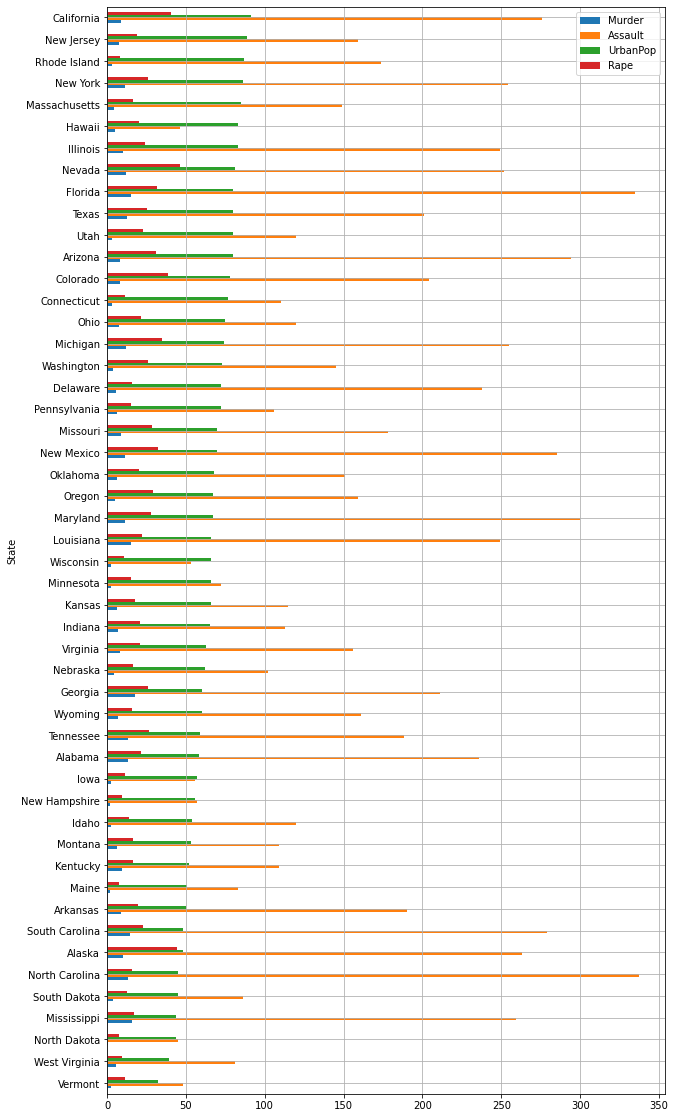

In [274]:
#cities with crime stats sorted by decending urban population
features_of_interest=pd.DataFrame({'Murder': grouped['Murder'],
                                     'Assault': grouped['Assault'],
                                     'UrbanPop': grouped['UrbanPop'],
                                     'Rape': grouped['Rape'],
                                    }
                                   )

features_of_interest.sort_values(by='UrbanPop',ascending=True).plot.barh(figsize=(10,20), grid=True)


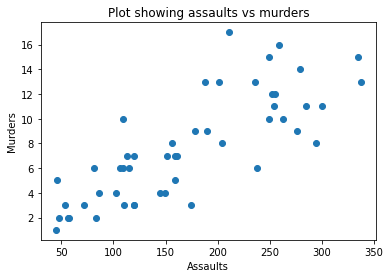

In [175]:
#plot with assault vs murder
fig,ax=plt.subplots()
plt.scatter(df['Assault'], df['Murder'])
plt.xlabel('Assaults')
plt.ylabel('Murders')
plt.title('Plot showing assaults vs murders')
plt.show()

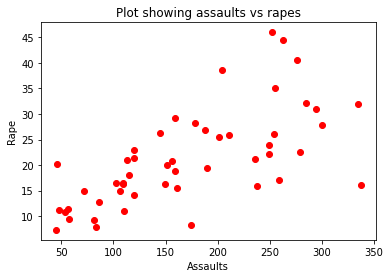

In [283]:
#plot showing no. assaults vs no. rapes
fig,ax=plt.subplots()
plt.scatter(df['Assault'], df['Rape'], color='r')
plt.xlabel('Assaults')
plt.ylabel('Rape')
plt.title('Plot showing assaults vs rapes')
plt.show()

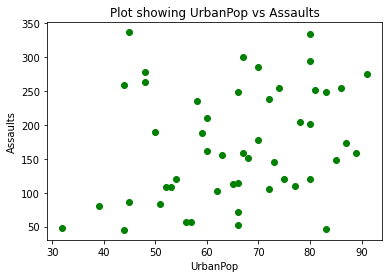

In [177]:
#more assaults the more violent crimes
#plot showing urban pop vs no of assaults
fig,ax=plt.subplots()
plt.scatter(df['UrbanPop'], df['Assault'], color='g')
plt.xlabel('UrbanPop')
plt.ylabel('Assaults')
plt.title('Plot showing UrbanPop vs Assaults')
plt.show()

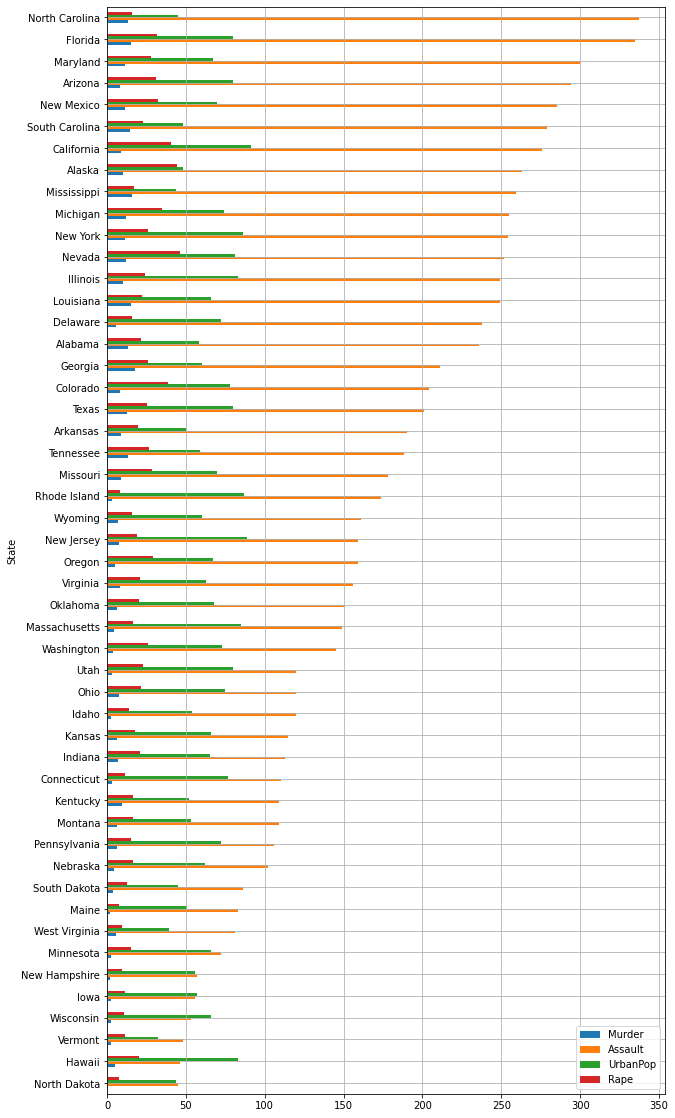

In [275]:
#less correlated as some with low urban populations have high no. assaults
#revisualisation of cities with all crime states, this time organised by number of assaults

features_of_interest.sort_values(by='Assault', ascending=True).plot.barh(figsize=(10,20), 
                                                                         grid=True)


In [179]:
#data exploration table
#row values
variable_list=list(df.columns[1:])

#mean value calculation for rows (variables)
mean_list=[]
for n in variable_list:
    mean_=df[n].mean()
    mean_list.append(mean_)
    
#standard deviation value calc    
stDev_list=[]
for n in variable_list:
    stDev=df[n].std()
    stDev_list.append(stDev)

#find min value 
min_list=[]
for n in variable_list:
    min_=df[n].min()
    min_list.append(min_)

#find max value
max_list=[]
for n in variable_list:
    max_=df[n].max()
    max_list.append(max_)

#create and fill table
exploration_table=pd.DataFrame(columns=['Variable', 'Mean', 'StandardDeviation', 'Min', 'Max'])
exploration_table['Variable']=variable_list
exploration_table['Mean']=mean_list
exploration_table['StandardDeviation']=stDev_list
exploration_table['Min']=min_list
exploration_table['Max']=max_list

exploration_table


,Variable,Mean,StandardDeviation,Min,Max
0,Murder,7.70,4.282141,1,17
1,Assault,170.76,83.337661,45,337
2,UrbanPop,65.54,14.474763,32,91
3,Rape,21.20,9.387356,7,46


In [291]:
#define and scale data
X=df[['Murder', 'Assault', 'UrbanPop', 'Rape']].values.reshape(-1,4)
print('Shape of data:' , X.shape)

X_sc=StandardScaler().fit_transform(X)


Shape of data: (50, 4)


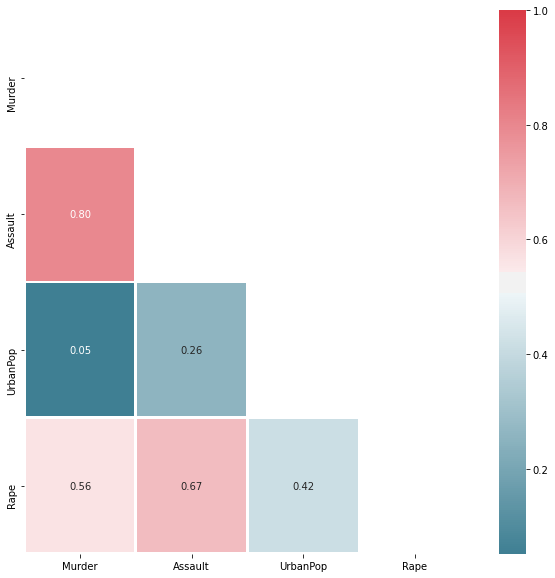

In [296]:
#correlation heatmap 
colormap=sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
    corrs=df.corr()
    fig,ax=plt.subplots(figsize=(10,10))
    #maskl mirrored side
    dropSelf=np.zeros_like(corrs)
    dropSelf[np.triu_indices_from(dropSelf)]=True
    ax=sns.heatmap(corrs, cmap=colormap, annot=True, 
                   fmt='.2f', mask=dropSelf, linewidth=2)

corr_heatmap(df)


In [301]:
#PCA
#number of components
n_comps=4
pca=PCA(n_components=n_comps)
#get components
principal_comps=pca.fit_transform(X_sc)
#set index
df=df.set_index(df['State'])
#convert into pandas df
pca_df=pd.DataFrame(principal_comps, index=df.index)
pca_df.head()


,0,1,2,3
State,,,,
Alabama,0.973443,1.137456,-0.447886,0.154435
Alaska,1.944930,1.072333,1.970804,-0.495486
Arizona,1.763090,-0.759802,0.019030,-0.825085
Arkansas,-0.068707,1.137808,0.140946,-0.148449
California,2.560137,-1.551867,0.594716,-0.318694


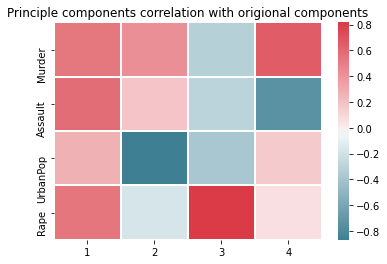

In [302]:
#principle components vs origional components
components=pd.DataFrame(pca.components_, columns=variable_list, index=range(1, n_comps+1)).transpose()
ax=sns.heatmap(components, cmap=colormap, linewidth=1)
plt.title('Principle components correlation with origional components')
plt.show()


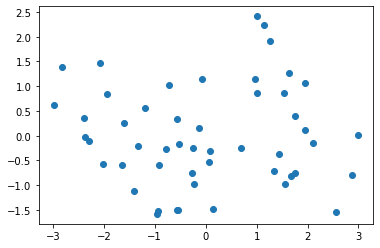

In [184]:
#plot 1st and 2nd pca against each other
X_pca=pca_df[[0,1]]

fig,ax=plt.subplots()
plt.scatter(X_pca[[0]], X_pca[[1]])
plt.show()


[0.6188744600252495, 0.8698663169461914, 0.9567074611088462, 0.9999999999999999]


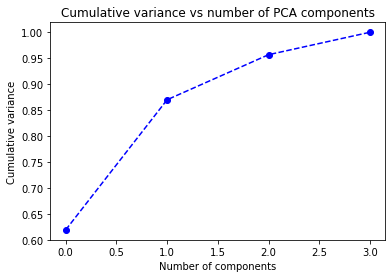

In [185]:
#Cumulative variance explained:
pca_cv=PCA(n_components=4)
pca_cv.fit_transform(X_sc)

#cumulative variance variable
i=0
cumulative_variance_exp=[]
for i in range(0, 4):
    if i==0:
        cumulative_variance_exp.append(pca_cv.explained_variance_ratio_[i])
    else:
        cumulative_variance_exp.append(pca_cv.explained_variance_ratio_[i]+
                                       cumulative_variance_exp[i-1])
        
print(cumulative_variance_exp)     
plt.plot(cumulative_variance_exp, color='blue', marker='o',
        linestyle='dashed')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.title('Cumulative variance vs number of PCA components')
plt.show()


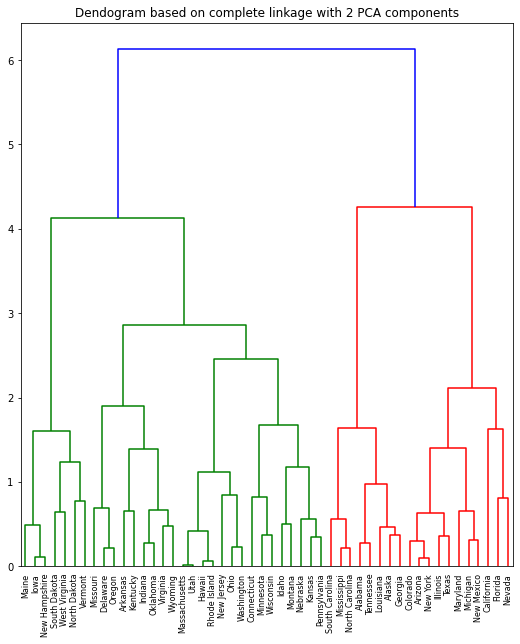

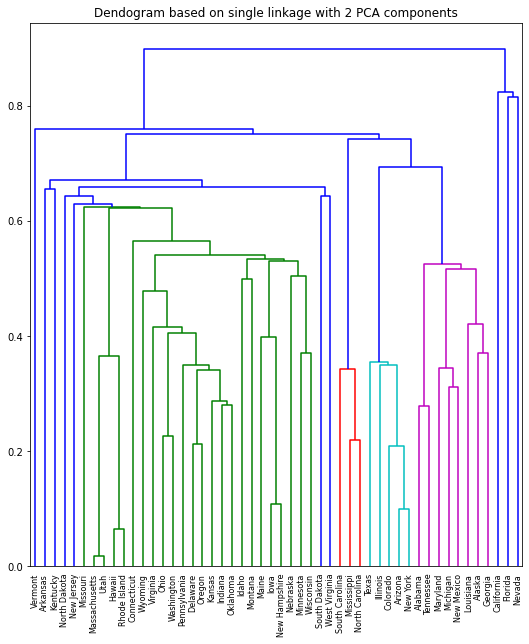

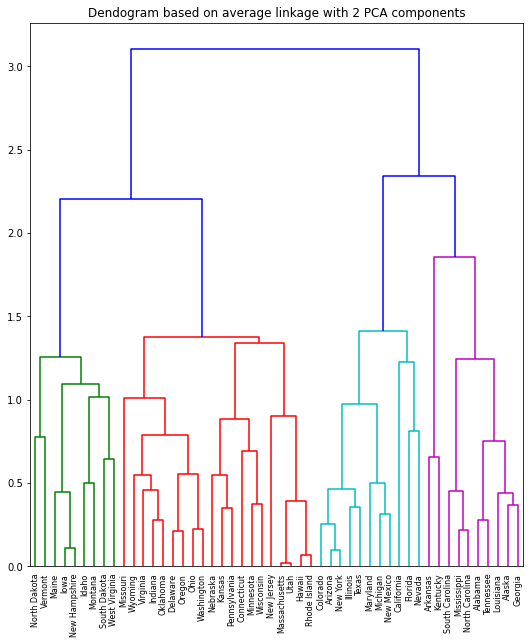

In [305]:
#agglomerative clustering with 2 PCA components
linkage_types=['complete','single','average']

for i, l in enumerate(linkage_types):
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,i+1)
    dend=dendrogram(linkage(X_pca, method=l), labels=df['State'])
    plt.title('Dendogram based on {} linkage with 2 PCA components'.format(l))
    plt.show()


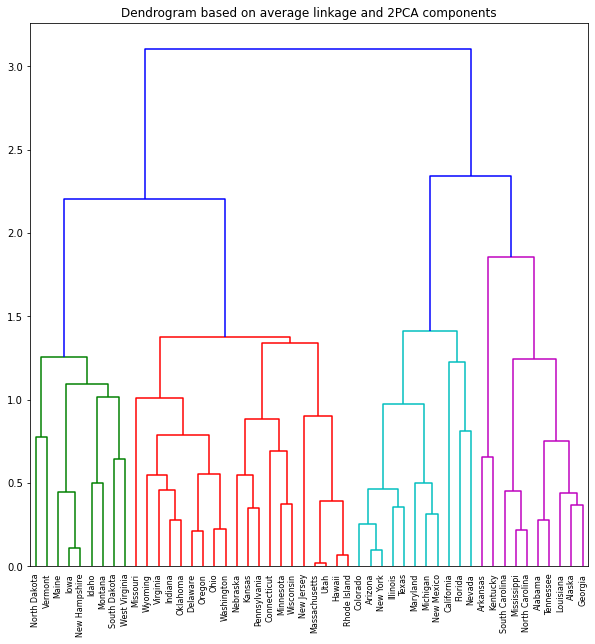

In [248]:
#dendrogram based on average linkage
plt.figure(figsize=(10,10))
dend_avg=dendrogram(linkage(X_pca, method='average'), labels=df['State'])
plt.title('Dendrogram based on average linkage and 2PCA components')
plt.show()


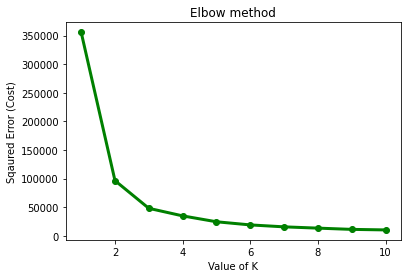

In [247]:
#elbow plot to determine optimal k value
cost=[] 
for i in range(1, 11): 
    KM=KMeans(n_clusters=i, max_iter=500) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color='g', linewidth='3', marker='o') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.title('Elbow method')
plt.show() 


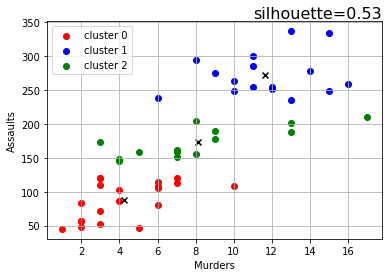

In [334]:
#k-means clustering into 3 clusters
from sklearn.cluster import KMeans

def Kmeans_plot(x, k=3, r=123):
    kmeans=KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred=kmeans.fit_predict(x)
    colors='rbgcmy'
    for c in range(k):
        plt.scatter(x[y_pred==c,0], x[y_pred==c,1], c=colors[c],
                    label='cluster {}'.format(c))
        plt.scatter(kmeans.cluster_centers_[c,0], kmeans.cluster_centers_[c,1],
                   marker='x', color='black')
        
    score=round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Murders')
    plt.ylabel('Assaults')
    plt.legend()
    plt.grid()
    plt.show()
    
Kmeans_plot(X, k=3, r=0)
